# Speeding up inference with TensorRT

Does Nvidia's TensorRT speed up inference on Nvidia GPUs?

Right now I'm using a Titan RTX (faster inference may only be with Nvidia A100) but I'd like to see if TensorRT improves inference time.

Improved inference time = faster evaluation.

See these resources:
* https://developer.nvidia.com/blog/accelerating-inference-up-to-6x-faster-in-pytorch-with-torch-tensorrt/ 

In [12]:
# Append the upper level directory to sys
import sys
from tqdm.auto import tqdm
sys.path.append("..")

from configs.default_config import config

args = config
args.num_top_n_preds = 5

GS_BUCKET_NAME = config.gs_bucket_name

import pandas as pd
import numpy as np

from pathlib import Path

In [1]:
# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels



run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['test_inference_time_with_tensorrt'],
                 notes="testing inference time with TensorRT")

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrdbourke. Use `wandb login --relogin` to force relogin


[INFO] Labels directory: ./artifacts/food_vision_labels:v27
[INFO] Labels path: artifacts/food_vision_labels:v27/annotations.csv
[INFO] Working with: 208 classes


In [7]:
args.image_size = 224
args.wandb_model_artifact

'trained_model:latest'

In [13]:
import torch
import timm
from timm.data import create_transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the data transform
transform = create_transform(input_size=args.image_size, is_training=False)

In [14]:
# Download model artifact
model_at_dir = wandb_load_artifact(wandb_run=run,
                                   artifact_name=args.wandb_model_artifact,
                                   artifact_type="model")
print(f"[INFO] Model artifact directory: {model_at_dir}")

# Get list of all files with "*.pth" in model_at_dir
model_path = str(list(Path(model_at_dir).rglob("*.pth"))[0])
print(f"[INFO] Model path: {model_path}")

# Create the model with timm
model = timm.create_model(
    model_name=args.model, pretrained=args.pretrained, num_classes=len(class_dict)
)
model.load_state_dict(torch.load(model_path))

# Create the data transform
transform = create_transform(input_size=args.image_size, is_training=False)

def pred_on_image(
    model,
    class_dict,
    image_path,
    transform=transform,
    device=device,
    num_top_n_preds=args.num_top_n_preds,
):
    """Makes a predition on a single image.

    Args:
        model (_type_): A trained PyTorch model.
        class_dict (Dict): Mapping of class labels to class names.
        image_path (str): String path to target image.
        transform (_type_): Transform to perform on image before being passed to model.
        device (torch.device): Device to make prediction on (e.g. "cuda" or "cpu").
        num_top_n_preds (int, optional): Number of top_n predictions to return. Defaults to 5.

    Returns:
        dict: a dictionary containing the image path, the top n predictions, and the top n prediction probabilities.
        For example:

            pred_dict = {
                "image_path": image_path,
                "pred_label": pred_label,
                "pred_prob": pred_prob.max().item(),
                "pred_class": pred_class,
                "top_n_preds": top_n_pred_dict}
    """

    # Open image
    img = Image.open(image_path)

    # Make sure model on target device
    model.to(device)

    # Turn on model eval mode and make prediction
    model.eval()
    with torch.inference_mode():
        try:
            img_tensor = transform(img).unsqueeze(0).to(device)
            pred = model(img_tensor)
            pred_prob = torch.softmax(pred, dim=1)
            pred_label = pred_prob.argmax().item()
            pred_class = class_dict[pred_label]

            # Get top_n predictions
            top_n_pred_tensor = pred_prob.topk(num_top_n_preds)
            top_n_pred_probs = top_n_pred_tensor.values.tolist()[0]
            top_n_pred_labels = top_n_pred_tensor.indices.tolist()[0]
            top_n_pred_classes = [class_dict[i] for i in top_n_pred_labels]

            # Zip together top_n_pred_labels and top_n_pred_classes
            top_n_pred_dict = [
                {"pred_prob": pred_prob, "pred_label": pred_label, "pred_class": pred_class}
                for pred_prob, pred_label, pred_class in zip(
                    top_n_pred_probs, top_n_pred_labels, top_n_pred_classes
                )
            ]

            # Create pred dict
            pred_dict = {
                "image_path": image_path,
                "pred_label": pred_label,
                "pred_prob": pred_prob.max().item(),
                "pred_class": pred_class,
                "top_n_preds": top_n_pred_dict,
            }

            return pred_dict
        
        except Exception as e:
            print(f"[ERROR] Error making prediction on image: {image_path}, continuing...")
            print(e)
            return None

wandb: Downloading large artifact trained_model:latest, 54.61MB. 1 files... Done. 0:0:0.0


[INFO] Model artifact directory: ./artifacts/trained_model:v42
[INFO] Model path: artifacts/trained_model:v42/2023-02-15_17-08-10_model_coatnext_nano_rw_224.pth


## Create a benchmark

In [20]:
import torch_tensorrt
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [35]:
import time

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))

In [97]:
# Benchmark the baseline model
model.to(device)
benchmark(model, input_shape=(1, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=1000)

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 7.22 ms
Iteration 20/1000, avg batch time 7.26 ms
Iteration 30/1000, avg batch time 7.33 ms
Iteration 40/1000, avg batch time 7.43 ms
Iteration 50/1000, avg batch time 7.42 ms
Iteration 60/1000, avg batch time 7.41 ms
Iteration 70/1000, avg batch time 7.38 ms
Iteration 80/1000, avg batch time 7.36 ms
Iteration 90/1000, avg batch time 7.36 ms
Iteration 100/1000, avg batch time 7.36 ms
Iteration 110/1000, avg batch time 7.36 ms
Iteration 120/1000, avg batch time 7.36 ms
Iteration 130/1000, avg batch time 7.36 ms
Iteration 140/1000, avg batch time 7.35 ms
Iteration 150/1000, avg batch time 7.35 ms
Iteration 160/1000, avg batch time 7.35 ms
Iteration 170/1000, avg batch time 7.35 ms
Iteration 180/1000, avg batch time 7.34 ms
Iteration 190/1000, avg batch time 7.34 ms
Iteration 200/1000, avg batch time 7.33 ms
Iteration 210/1000, avg batch time 7.33 ms
Iteration 220/1000, avg batch time 7.33 ms
Iteration 230/1000, avg batch time

In [98]:
# Try with TorchScript JIT
model_jit = torch.jit.trace(model, torch.randn((1, 3, 224, 224)).to(device))
model_jit.to(device)
benchmark(model_jit, input_shape=(1, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=1000)

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 5.66 ms
Iteration 20/1000, avg batch time 5.64 ms
Iteration 30/1000, avg batch time 5.65 ms
Iteration 40/1000, avg batch time 5.68 ms
Iteration 50/1000, avg batch time 5.68 ms
Iteration 60/1000, avg batch time 5.67 ms
Iteration 70/1000, avg batch time 5.67 ms
Iteration 80/1000, avg batch time 5.68 ms
Iteration 90/1000, avg batch time 5.76 ms
Iteration 100/1000, avg batch time 5.78 ms
Iteration 110/1000, avg batch time 5.78 ms
Iteration 120/1000, avg batch time 5.78 ms
Iteration 130/1000, avg batch time 5.77 ms
Iteration 140/1000, avg batch time 5.76 ms
Iteration 150/1000, avg batch time 5.76 ms
Iteration 160/1000, avg batch time 5.76 ms
Iteration 170/1000, avg batch time 5.75 ms
Iteration 180/1000, avg batch time 5.74 ms
Iteration 190/1000, avg batch time 5.74 ms
Iteration 200/1000, avg batch time 5.74 ms
Iteration 210/1000, avg batch time 5.74 ms
Iteration 220/1000, avg batch time 5.74 ms
Iteration 230/1000, avg batch time

In [99]:
# Try with TensorRT
# model = model.eval()
trt_model = torch_tensorrt.compile(
    model.eval(), 
    inputs=[
        torch_tensorrt.Input(
        (1, 3, 224, 224))
    ],
    enabled_precisions={torch.float32},
    require_full_compilation=False,
)

In [100]:
benchmark(trt_model, input_shape=(1, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=1000)

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 4.53 ms
Iteration 20/1000, avg batch time 3.80 ms
Iteration 30/1000, avg batch time 3.57 ms
Iteration 40/1000, avg batch time 3.44 ms
Iteration 50/1000, avg batch time 3.35 ms
Iteration 60/1000, avg batch time 3.30 ms
Iteration 70/1000, avg batch time 3.26 ms
Iteration 80/1000, avg batch time 3.43 ms
Iteration 90/1000, avg batch time 3.39 ms
Iteration 100/1000, avg batch time 3.36 ms
Iteration 110/1000, avg batch time 3.33 ms
Iteration 120/1000, avg batch time 3.30 ms
Iteration 130/1000, avg batch time 3.28 ms
Iteration 140/1000, avg batch time 3.26 ms
Iteration 150/1000, avg batch time 3.25 ms
Iteration 160/1000, avg batch time 3.23 ms
Iteration 170/1000, avg batch time 3.22 ms
Iteration 180/1000, avg batch time 3.21 ms
Iteration 190/1000, avg batch time 3.20 ms
Iteration 200/1000, avg batch time 3.19 ms
Iteration 210/1000, avg batch time 3.19 ms
Iteration 220/1000, avg batch time 3.18 ms
Iteration 230/1000, avg batch time

## Try with real data

In [101]:
from PIL import Image

# Get the image paths
import glob
import os

food_images = glob.glob(os.path.join("food_photos/*", "*.jp*g"))
food_images[:10]
# image_paths

['food_photos/cashews/96237783-2f60-4f2d-983a-f1b289067887.jpeg',
 'food_photos/cashews/3ab541fe-7b51-4382-acaa-98e895dd995f.jpeg',
 'food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da4054f6d03f.jpeg',
 'food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b7a9cf66600.jpeg',
 'food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f25a15241af.jpeg',
 'food_photos/orange_juice/64eaaf1b-6e71-4511-8ecb-d3a38c06a3d6.jpeg',
 'food_photos/orange_juice/fa15a4e4-63b2-4491-88fa-095301c34fe0.jpeg',
 'food_photos/grapes_red/ab2835cd-0437-4be2-8ba9-af9f83a5552d.jpeg',
 'food_photos/grapes_red/8f5f13fe-2faa-4b02-b8a8-5690a28ad429.jpeg',
 'food_photos/grapes_red/3d66e684-4f4a-413e-8768-9ee0226df0ad.jpeg']

In [102]:
len(food_images)

1381

In [103]:
normal_preds = []
for image in tqdm(food_images):
    start_time = time.time()
    pred_dict = pred_on_image(model, class_dict, image)
    end_time = time.time()
    pred_dict["pred_time"] = end_time - start_time
    normal_preds.append(pred_dict)
    # print(pred_dict)

  0%|          | 0/1381 [00:00<?, ?it/s]

In [104]:
# Try with JIT model
jit_preds = []
for image in tqdm(food_images):
    start_time = time.time()
    pred_dict = pred_on_image(model_jit, class_dict, image)
    end_time = time.time()
    pred_dict["pred_time"] = end_time - start_time
    jit_preds.append(pred_dict)

  0%|          | 0/1381 [00:00<?, ?it/s]

In [105]:
# Try with TensorRT model
trt_preds = []
for image in tqdm(food_images):
    start_time = time.time()
    pred_dict = pred_on_image(trt_model, class_dict, image)
    end_time = time.time()
    pred_dict["pred_time"] = end_time - start_time
    trt_preds.append(pred_dict)

  0%|          | 0/1381 [00:00<?, ?it/s]

## Compare the pred times

In [110]:
import pandas as pd
normal_pred_df = pd.DataFrame(normal_preds)
jit_pred_df = pd.DataFrame(jit_preds)
trt_pred_df = pd.DataFrame(trt_preds)

# Add the ground truth names
normal_pred_df["ground_truth"] = normal_pred_df["image_path"].apply(lambda x: x.split("/")[-2])
jit_pred_df["ground_truth"] = jit_pred_df["image_path"].apply(lambda x: x.split("/")[-2])
trt_pred_df["ground_truth"] = trt_pred_df["image_path"].apply(lambda x: x.split("/")[-2])

<BarContainer object of 3 artists>

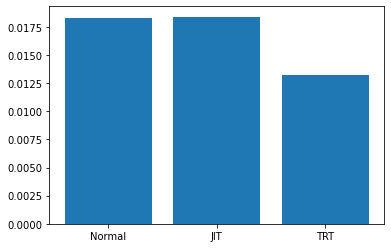

In [111]:
# Get the average pred times
avg_norm_pred_time = normal_pred_df["pred_time"].mean()
avg_jit_pred_time = jit_pred_df["pred_time"].mean()
avg_trt_pred_time = trt_pred_df["pred_time"].mean()

# Plot the pred times
import matplotlib.pyplot as plt

plt.bar(["Normal", "JIT", "TRT"], [avg_norm_pred_time, avg_jit_pred_time, avg_trt_pred_time])


## Compare the results

<BarContainer object of 3 artists>

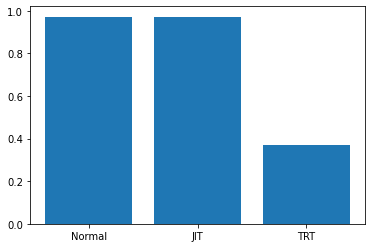

In [112]:
# Get the accuracy of each model by comparing pred_class to ground_truth
normal_pred_df["pred_correct"] = normal_pred_df["pred_class"] == normal_pred_df["ground_truth"]
jit_pred_df["pred_correct"] = jit_pred_df["pred_class"] == jit_pred_df["ground_truth"]
trt_pred_df["pred_correct"] = trt_pred_df["pred_class"] == trt_pred_df["ground_truth"]

# Get the average accuracy
avg_norm_acc = normal_pred_df["pred_correct"].mean()
avg_jit_acc = jit_pred_df["pred_correct"].mean()
avg_trt_acc = trt_pred_df["pred_correct"].mean()

# Plot the accuracy
plt.bar(["Normal", "JIT", "TRT"], [avg_norm_acc, avg_jit_acc, avg_trt_acc])


In [113]:
avg_norm_acc, avg_jit_acc, avg_trt_acc

(0.9724837074583635, 0.9724837074583635, 0.37074583635047065)

In [114]:
trt_pred_df.head()

,image_path,pred_label,pred_prob,pred_class,top_n_preds,pred_time,ground_truth,pred_correct
0,food_photos/cashews/96237783-2f60-4f2d-983a-f1...,38,0.861023,cashews,"[{'pred_prob': 0.8610230088233948, 'pred_label...",0.014597,cashews,True
1,food_photos/cashews/3ab541fe-7b51-4382-acaa-98...,38,0.728644,cashews,"[{'pred_prob': 0.7286444306373596, 'pred_label...",0.015194,cashews,True
2,food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...,38,0.584166,cashews,"[{'pred_prob': 0.5841659307479858, 'pred_label...",0.014028,cashews,True
3,food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...,38,0.477929,cashews,"[{'pred_prob': 0.47792866826057434, 'pred_labe...",0.014700,cashews,True
4,food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...,38,0.283621,cashews,"[{'pred_prob': 0.28362125158309937, 'pred_labe...",0.013644,cashews,True


In [115]:
# Show all the rows where the prediction was incorrect
trt_pred_df[trt_pred_df["pred_correct"] == False]

,image_path,pred_label,pred_prob,pred_class,top_n_preds,pred_time,ground_truth,pred_correct
5,food_photos/orange_juice/64eaaf1b-6e71-4511-8e...,94,0.752481,ice_coffee,"[{'pred_prob': 0.7524810433387756, 'pred_label...",0.011425,orange_juice,False
6,food_photos/orange_juice/fa15a4e4-63b2-4491-88...,183,0.338369,soda,"[{'pred_prob': 0.3383690416812897, 'pred_label...",0.013366,orange_juice,False
7,food_photos/grapes_red/ab2835cd-0437-4be2-8ba9...,35,0.277301,candy,"[{'pred_prob': 0.27730095386505127, 'pred_labe...",0.013261,grapes_red,False
8,food_photos/grapes_red/8f5f13fe-2faa-4b02-b8a8...,163,0.258178,rhubarb,"[{'pred_prob': 0.2581775188446045, 'pred_label...",0.013421,grapes_red,False
9,food_photos/grapes_red/3d66e684-4f4a-413e-8768...,35,0.809712,candy,"[{'pred_prob': 0.8097115755081177, 'pred_label...",0.013802,grapes_red,False
...,...,...,...,...,...,...,...,...
1372,food_photos/tea/3108aa69-9a6a-44cc-b2e8-bd52d6...,94,0.171884,ice_coffee,"[{'pred_prob': 0.17188429832458496, 'pred_labe...",0.011276,tea,False
1373,food_photos/tea/a15bb642-c99f-4993-b8ec-d54fc5...,94,0.740706,ice_coffee,"[{'pred_prob': 0.7407059669494629, 'pred_label...",0.012002,tea,False
1374,food_photos/tea/b1e8a40f-ae3e-4b18-a45d-69c2a5...,163,0.284865,rhubarb,"[{'pred_prob': 0.284864604473114, 'pred_label'...",0.011706,tea,False
1375,food_photos/tea/20df8dbb-53c0-441e-910a-b69b08...,94,0.258661,ice_coffee,"[{'pred_prob': 0.2586609721183777, 'pred_label...",0.011749,tea,False


In [116]:
trt_pred_df.pred_class.value_counts()

chilli          141
parsley         123
onion_green     120
apple_red        92
candy            90
               ... 
nuts              1
cabbage           1
dates             1
pork_belly        1
blackberries      1
Name: pred_class, Length: 91, dtype: int64

In [117]:
normal_pred_df.pred_class.value_counts()

grapes_red         164
lychee             164
broccolini         150
pear               140
fennel             137
corn               133
parsley            132
onion_green        126
chilli             112
tomato              29
celery              16
banana               7
cashews              5
grapes_black         5
apple_green          5
cherries             4
radish               4
ice_coffee           4
brussel_sprouts      4
coriander            2
red_wine             2
garlic               2
roast_beef           2
tea                  2
apple_red            2
hot_chocolate        2
milk                 2
steak                2
biltong              2
rhubarb              1
chocolate            1
coffee               1
green_beans          1
prosciutto           1
mushrooms            1
soda                 1
dragonfruit          1
sushi                1
lemon                1
guava                1
lime                 1
candy                1
omelette             1
salami     

In [76]:
# Get the pred_class column of each df
normal_pred_results = normal_pred_df["pred_class"].tolist()
jit_pred_results = jit_pred_df["pred_class"].tolist()
trt_preds_results = trt_pred_df["pred_class"].tolist()

# Compare the preds
normal_preds == jit_preds == trt_preds

False

In [77]:
normal_preds == trt_preds

False

[{'pred_prob': 0.8633630275726318, 'pred_label': 35, 'pred_class': 'candy'}, {'pred_prob': 0.048798371106386185, 'pred_label': 66, 'pred_class': 'donuts'}, {'pred_prob': 0.042874593287706375, 'pred_label': 204, 'pred_class': 'watermelon'}, {'pred_prob': 0.02628566138446331, 'pred_label': 194, 'pred_class': 'tacos'}, {'pred_prob': 0.0028918928001075983, 'pred_label': 85, 'pred_class': 'grapes_red'}]


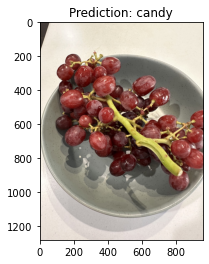

In [145]:
# Make a prediction on a single image
import random
image_0 = Image.open(random.choice(food_images))

# Create the data transform
transform = create_transform(input_size=args.image_size, is_training=False)

# Get the prediction
img_tensor = transform(image_0).unsqueeze(0).to(device)
pred = trt_model(img_tensor)
pred_prob = torch.softmax(pred, dim=1)
pred_label = pred_prob.argmax().item()
pred_class = class_dict[pred_label]

# Get top_n predictions
num_top_n_preds = 5
top_n_pred_tensor = pred_prob.topk(num_top_n_preds)
top_n_pred_probs = top_n_pred_tensor.values.tolist()[0]
top_n_pred_labels = top_n_pred_tensor.indices.tolist()[0]
top_n_pred_classes = [class_dict[i] for i in top_n_pred_labels]

# Zip together top_n_pred_labels and top_n_pred_classes
top_n_pred_dict = [
    {"pred_prob": pred_prob, "pred_label": pred_label, "pred_class": pred_class}
    for pred_prob, pred_label, pred_class in zip(
        top_n_pred_probs, top_n_pred_labels, top_n_pred_classes
    )
]

# Plot the image with the prediction
plt.imshow(image_0)
plt.title(f"Prediction: {pred_class}")
print(top_n_pred_dict)

In [122]:
pred_prob

tensor([[4.8746e-05, 4.2245e-04, 1.4585e-05, 9.2454e-05, 9.4705e-07, 1.8344e-05,
         1.9094e-05, 5.6030e-06, 2.1909e-07, 1.9811e-06, 4.5811e-03, 7.9217e-07,
         4.2875e-05, 1.2720e-06, 1.7798e-06, 8.9760e-05, 1.2103e-04, 1.7356e-06,
         4.7936e-05, 3.5259e-06, 4.8419e-07, 6.4325e-04, 1.4576e-07, 1.3586e-06,
         3.3056e-05, 7.8025e-05, 4.2469e-07, 1.8476e-06, 6.9679e-07, 1.3890e-05,
         9.0656e-07, 1.2320e-04, 9.5694e-06, 1.1001e-05, 2.9936e-06, 1.4408e-04,
         1.8906e-05, 2.0692e-04, 8.6102e-01, 1.3929e-05, 7.4300e-04, 7.0226e-06,
         1.4397e-05, 8.6136e-07, 5.8530e-08, 1.1631e-05, 1.6197e-04, 3.5252e-05,
         9.7398e-06, 2.5932e-04, 1.1400e-04, 1.1556e-05, 6.3681e-05, 6.8838e-06,
         6.6991e-04, 2.3635e-06, 1.1007e-03, 1.5027e-04, 3.0562e-06, 4.4325e-06,
         6.6506e-08, 4.7850e-06, 1.6692e-04, 3.9576e-04, 2.5338e-06, 1.4643e-04,
         2.1584e-05, 1.0281e-05, 8.1809e-07, 3.3761e-06, 4.6733e-07, 4.1119e-04,
         2.3452e-03, 7.8541e